In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# data
S = 100  # Current index price
r = 0.03  # Interest rate
strikes = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140])
maturities = np.array([0.25, 0.5, 1.0, 1.5])
call_prices = np.array([
    [40.2844, 42.4249, 50.8521, 59.1664],
    [30.5281, 33.5355, 42.6656, 51.2181],
    [21.0415, 24.9642, 34.4358, 42.9436],
    [12.2459, 16.9652, 26.4453, 34.7890],
    [5.2025, 10.1717, 19.4706, 27.8938],
    [1.3448, 5.4318, 14.4225, 23.3305],
    [0.2052, 2.7647, 11.2103, 20.7206],
    [0.0216, 1.4204, 9.1497, 19.1828],
    [0.0019, 0.7542, 7.7410, 18.1858]
])

In [3]:
# Black-Scholes formula for European call option price
def black_scholes_call(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [4]:
# Vega function: derivative of call price with respect to volatility
def vega(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

In [5]:
# Implied volatility using Newton-Raphson method
def implied_volatility_newton(C_market, S, K, T, r, tol=1e-6, max_iter=100):
    sigma = 0.2  # Initial guess for volatility
    epsilon = 1e-8  # Small epsilon to prevent division by zero

    for i in range(max_iter):
        price = black_scholes_call(S, K, T, r, sigma)
        vega_value = vega(S, K, T, r, sigma)
        
        # Check for valid vega_value to avoid division by zero
        if np.isnan(price) or np.isnan(vega_value) or vega_value < epsilon:
            return np.nan

        price_diff = price - C_market
        
        # Update step
        sigma_new = sigma - price_diff / vega_value
        
        # Check for convergence
        if abs(sigma_new - sigma) < tol:
            return sigma_new
        
        sigma = sigma_new

    # If convergence not reached, return NaN
    return np.nan

# Compute implied volatilities using Newton-Raphson
implied_vols = np.zeros(call_prices.shape)

for i, K in enumerate(strikes):
    for j, T in enumerate(maturities):
        implied_vols[i, j] = implied_volatility_newton(call_prices[i, j], S, K, T, r)

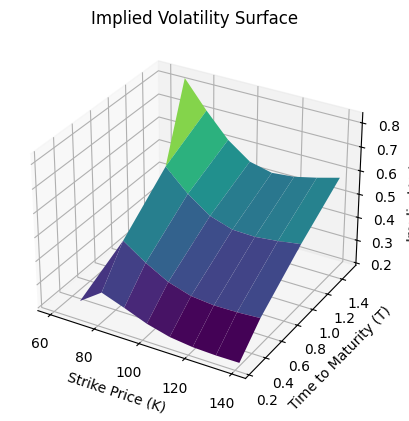

In [8]:
# Part I: Plotting the volatility surface without interpolation
K_grid, T_grid = np.meshgrid(strikes, maturities)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(K_grid, T_grid, implied_vols.T, cmap='viridis')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

plt.show()

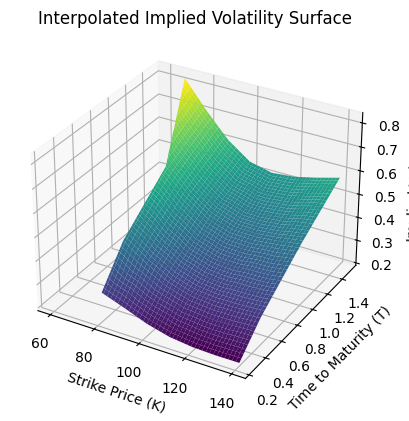

In [9]:
from scipy.interpolate import griddata

# Part II: Interpolation of the Implied Volatility Surface

# Define a finer grid for interpolation
K_fine = np.linspace(strikes.min(), strikes.max(), 1000)  # 1000 points between the min and max strikes
T_fine = np.linspace(maturities.min(), maturities.max(), 1000)  # 1000 points between the min and max maturities
K_grid_fine, T_grid_fine = np.meshgrid(K_fine, T_fine)

# Flatten the original grid points and the corresponding implied volatilities
K_flat = K_grid.flatten()
T_flat = T_grid.flatten()
implied_vols_flat = implied_vols.T.flatten()

# Perform bilinear interpolation using griddata
implied_vols_interpolated = griddata(
    (K_flat, T_flat),  # Original grid points
    implied_vols_flat,  # Corresponding implied volatilities
    (K_grid_fine, T_grid_fine),  # New grid points for interpolation
    method='linear'  # Bilinear interpolation
)

# Plot the interpolated volatility surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid_fine, T_grid_fine, implied_vols_interpolated, cmap='viridis')

ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Interpolated Implied Volatility Surface')

plt.show()